In [1]:
options(repr.matrix.max.cols=30, repr.matrix.max.rows=20)
options(repr.vector.max.items = 50)
library(ggplot2)
library(dplyr)
library(Matrix)
library(data.table)
library(magrittr)
library(IRdisplay)
library(parallel)
library(stringr)
library(purrr)
library(patchwork)
library(glue)
library(ggridges)
library(numbat)
R.utils::sourceDirectory('~/numbat/R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘purrr’


The following object is masked from ‘package:magrittr’:

    set_names


The following object is masked from ‘package:data.table’:

    transpose


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

Warning message:
“replacing previous import ‘Matrix::expand’ by ‘ggtree::expand’ when loading ‘numbat’”


In [2]:
cell_annot = fread('~/paper_data/cell_annotations/cell_annot_WASHU_march.tsv') %>%
    split(.$sample)

gene_order = fread('~/inferCNV/hg38_gene_order.txt') %>% 
    setNames(c('gene', 'CHROM', 'start', 'end'))

# con_washu = readRDS("~/paper_data/conos_objects/conos_WASHU.rds")

In [6]:
res = c()
scores = c()

# Scoring functions

In [59]:
score_copykat = function(sample, segs_consensus, ref = 'hca') {
    
    cna = fread(glue('~/paper_data/copykat_out/{sample}/{sample}_copykat_CNA_results.txt')) %>%
        as.data.frame() %>%
        rename(CHROM = chrom, POS = chrompos) %>%
        mutate(CHROM = factor(CHROM, 1:22)) %>%
        filter(!is.na(CHROM))

    colnames(cna) = colnames(cna) %>% str_remove('^X') %>% str_replace('\\.1', '-1')

    cna = cna %>% mutate(snp_id = 1:n()) %>%
        annot_consensus(segs_consensus) %>%
        select(CHROM, POS, seg, cnv_state, any_of(cell_annot[[sample]]$cell))

    # normalize the baseline
    cna.norm = cna

    baseline = cna %>% filter(cnv_state == 'neu') %>% 
        select(any_of(cell_annot[[sample]]$cell)) %>% colMeans()

    cna.norm[,5:ncol(cna.norm)] = sweep(cna[,5:ncol(cna)], 2, baseline)

    scores = rbind(
            cna.norm %>% mutate(norm = T),
            cna %>% mutate(norm = F)
        ) %>%
        mutate(CHROM = as.factor(CHROM)) %>%
        reshape2::melt(id.vars = c('CHROM', 'POS', 'seg', 'cnv_state', 'norm'), variable.name = 'cell', value.name = 'score') %>%
        group_by(cell, CHROM, seg, cnv_state, norm) %>%
        summarise(score = mean(score), .groups = 'drop') %>%
        ungroup() %>%
        mutate(score = ifelse(cnv_state == 'del', -score, score)) %>%
        mutate(method = 'copykat')
    
    return(list('scores' = scores, 'cna' = cna, 'cna.norm' = cna.norm))
}

score_infercnv = function(sample, segs_consensus, ref = 'hca') {
    
    cna = fread(glue('~/paper_data/infercnv_out/{sample}/infercnv.observations.txt')) %>%
        rename(gene = V1) %>% suppressWarnings()
    
    cna[,2:ncol(cna)] = cna[,2:ncol(cna)] - 1
    
    cna = cna %>% 
        left_join(gene_order, by = 'gene') %>%
        mutate(CHROM = str_remove(CHROM, 'chr'), .before = 1) %>%
        filter(CHROM %in% 1:22) %>%
        mutate(CHROM = factor(CHROM, 1:22)) %>%
        mutate(snp_id = 1:n()) %>%
        mutate(POS = start) %>%
        annot_consensus(segs_consensus) %>%
        select(CHROM, POS, seg, cnv_state, any_of(cell_annot[[sample]]$cell))

    # normalize the baseline
    cna.norm = cna
    baseline = cna %>% filter(cnv_state == 'neu') %>% 
        select(any_of(cell_annot[[sample]]$cell)) %>% colMeans()

    cna.norm[,5:ncol(cna.norm)] = sweep(cna[,5:ncol(cna)], 2, baseline)
    
    scores = rbind(
            cna.norm %>% mutate(norm = T),
            cna %>% mutate(norm = F)
        ) %>%
        reshape2::melt(id.vars = c('CHROM', 'POS', 'seg', 'cnv_state', 'norm'), variable.name = 'cell', value.name = 'score') %>%
        group_by(cell, CHROM, seg, cnv_state, norm) %>%
        summarise(score = mean(score), .groups = 'drop') %>%
        ungroup() %>%
        mutate(score = ifelse(cnv_state == 'del', -score, score)) %>%
        mutate(method = 'infercnv')
    
    return(list('scores' = scores, 'cna' = cna, 'cna.norm' = cna.norm))
}

load_purple = function(sample) {
    cob_segs = fread(glue('~/paper_data/purple_out/{sample}/cobalt/{sample}.cobalt.ratio.pcf')) %>%
        rename(CHROM = chrom) %>%
        mutate(CHROM = str_remove(CHROM, 'chr'))  %>%
        filter(CHROM %in% 1:22) %>%
        mutate(CHROM = factor(CHROM, unique(CHROM)))
    
    cob_markers = fread(glue('~/paper_data/purple_out/{sample}/cobalt/{sample}.cobalt.ratio.tsv')) %>%
        rename(CHROM = chromosome, POS = position) %>%
        mutate(logR = log2(tumorGCRatio)) %>%
        mutate(CHROM = str_remove(CHROM, 'chr'))  %>%
        filter(CHROM %in% 1:22) %>%
        filter(logR != -1) %>%
        mutate(CHROM = factor(CHROM, unique(CHROM)))

    amber = fread(glue('~/paper_data/purple_out/{sample}/amber/{sample}.amber.baf.tsv')) %>%
        rename(CHROM = chromosome) %>%
        mutate(CHROM = str_remove(CHROM, 'chr'))  %>%
        filter(CHROM %in% 1:22) %>%
        mutate(CHROM = factor(CHROM, unique(CHROM)))

    purple_cnv =  fread(glue('~/paper_data/purple_out/{sample}/purple/{sample}.purple.cnv.somatic.tsv')) %>%
        rename(CHROM = chromosome) %>%
        mutate(CHROM = str_remove(CHROM, 'chr'))  %>%
        filter(CHROM %in% 1:22) %>%
        mutate(CHROM = factor(CHROM, unique(CHROM)))

    purple_segments = fread(glue('~/paper_data/purple_out/{sample}/purple/{sample}.purple.segment.tsv')) %>%
        rename(CHROM = chromosome) %>%
        mutate(CHROM = str_remove(CHROM, 'chr'))  %>%
        filter(CHROM %in% 1:22) %>%
        mutate(CHROM = factor(CHROM, unique(CHROM)))
    
    f = glue('~/paper_data/purple_out/{sample}/purple/segs_new.tsv')
    
    if (file.exists(f)) {
        segs_smooth = fread(f) %>%
            mutate(CHROM = factor(CHROM, unique(CHROM)))
    } else {
        segs_smooth = NULL
    }
    
    return(list('cob_segs' = cob_segs, 'cob_markers' = cob_markers, 'amber' = amber,
                'cnv' = purple_cnv, 'segments' = purple_segments, 'segs_smooth' = segs_smooth))
}

# Plotting

In [60]:
plot_purple = function(purple) {
        
    purple$segments = purple$segments %>% mutate(aberrant = tumorCopyNumber > 2.5 | tumorCopyNumber < 1.5)
    
    purple$amber %>% 
    mutate(variable = factor('BAF', c('TCN', 'BAF'))) %>%
    sample_frac(0.2) %>%
    ggplot() +
    theme_classic() +
    theme(
        panel.spacing = unit(0,'mm'),
        axis.text.x = element_blank(),
        panel.border = element_rect(color = 'gray', size = 0.2, fill = NA)
    ) +
    geom_point(
        aes(x = position, y = tumorBAF),
        size = 0.2, alpha = 0.02, pch = 16
    ) +
    geom_segment(
        data = purple$segments %>% 
            filter(tumorCopyNumber < 5 & (end - start) > 1e6 & depthWindowCount > 10) %>%
            mutate(variable = factor('TCN', c('TCN', 'BAF'))),
        aes(x = start, xend = end, y = log2(tumorCopyNumber/2), yend = log2(tumorCopyNumber/2), color = aberrant),
        size = 1
    ) +
    geom_segment(
        data = purple$segments %>% 
            filter(bafCount > 30) %>%
        mutate(variable = factor('BAF', c('TCN', 'BAF'))),
        aes(x = start, xend = end, y = observedBAF, yend = observedBAF),
        size = 1,
        color = 'blue'
    ) +
    geom_segment(
        data = purple$segments %>% 
            filter(bafCount > 30) %>%
        mutate(variable = factor('BAF', c('TCN', 'BAF'))),
        aes(x = start, xend = end, y = 1-observedBAF, yend = 1-observedBAF),
        size = 1,
        color = 'blue'
    ) +
#     geom_rect(
#         data = acen %>% 
#             mutate(CHROM = str_remove(CHROM, 'chr')) %>% 
#             filter(CHROM %in% 1:22) %>%
#             mutate(CHROM = factor(CHROM)) %>%
#             group_by(CHROM) %>%
#             summarise(start = min(start), end = max(end)),
#         aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf),
#         fill = 'gray',
#         alpha = 0.5
#     ) +
    facet_grid(variable~CHROM, space = 'free_x', scale = 'free') +
    scale_color_manual(values = c('black', 'red')) +
    guides(color = 'none')
    # geom_hline(yintercept = 2/3, linetype = 'dashed', color = 'darkred', size = 0.5) +
    # geom_hline(yintercept = 1/3, linetype = 'dashed', color = 'darkred', size = 0.5) +
    # geom_hline(yintercept = 0.5, linetype = 'dashed', color = 'darkblue', size = 0.5)
    
}

# 37692

## DNA

Warning message in mask$eval_all_mutate(quo):
“NaNs produced”


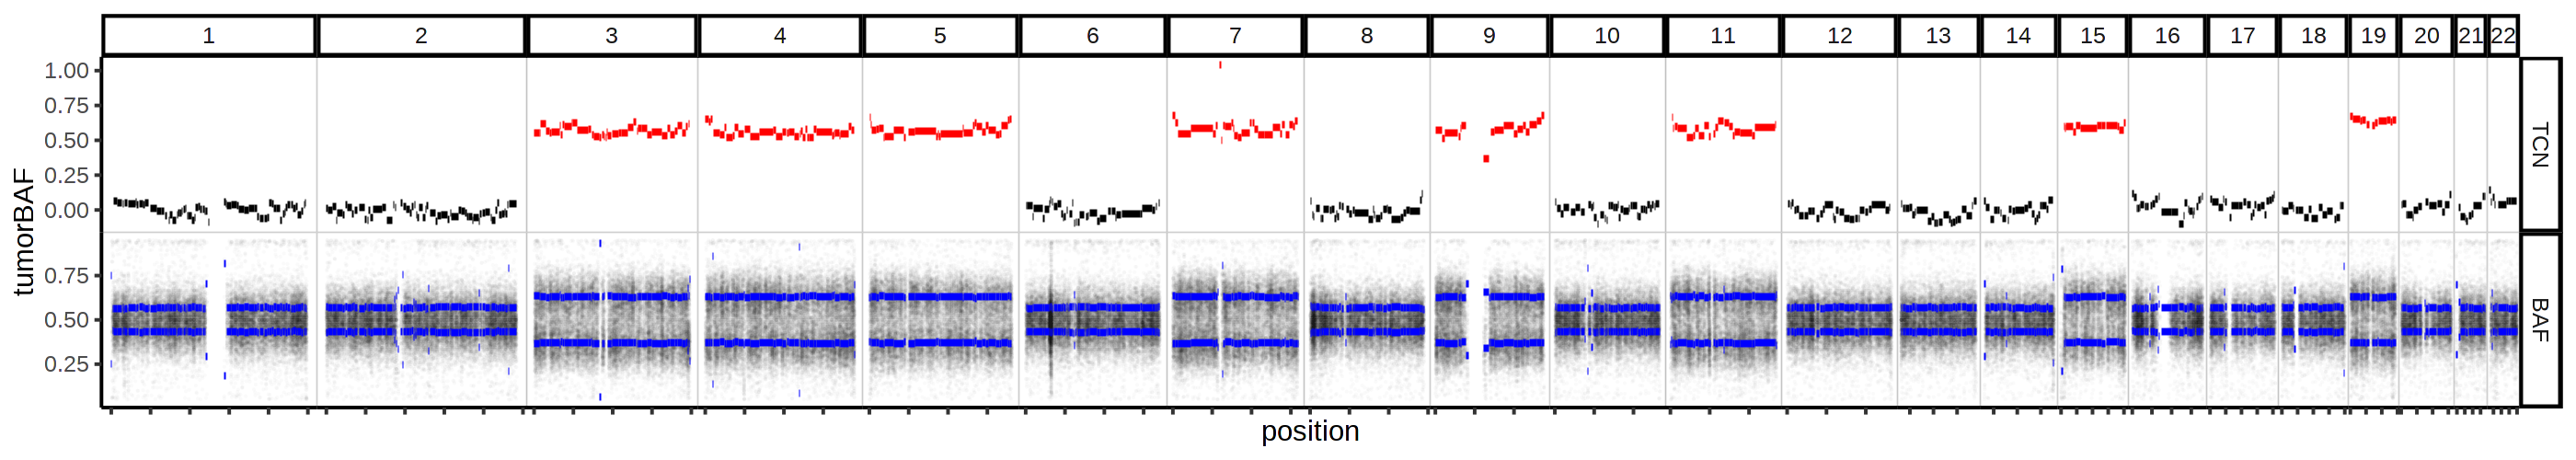

In [78]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
sample = '37692_Primary'

purple[[sample]] = load_purple(sample)

plot_purple(purple[[sample]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



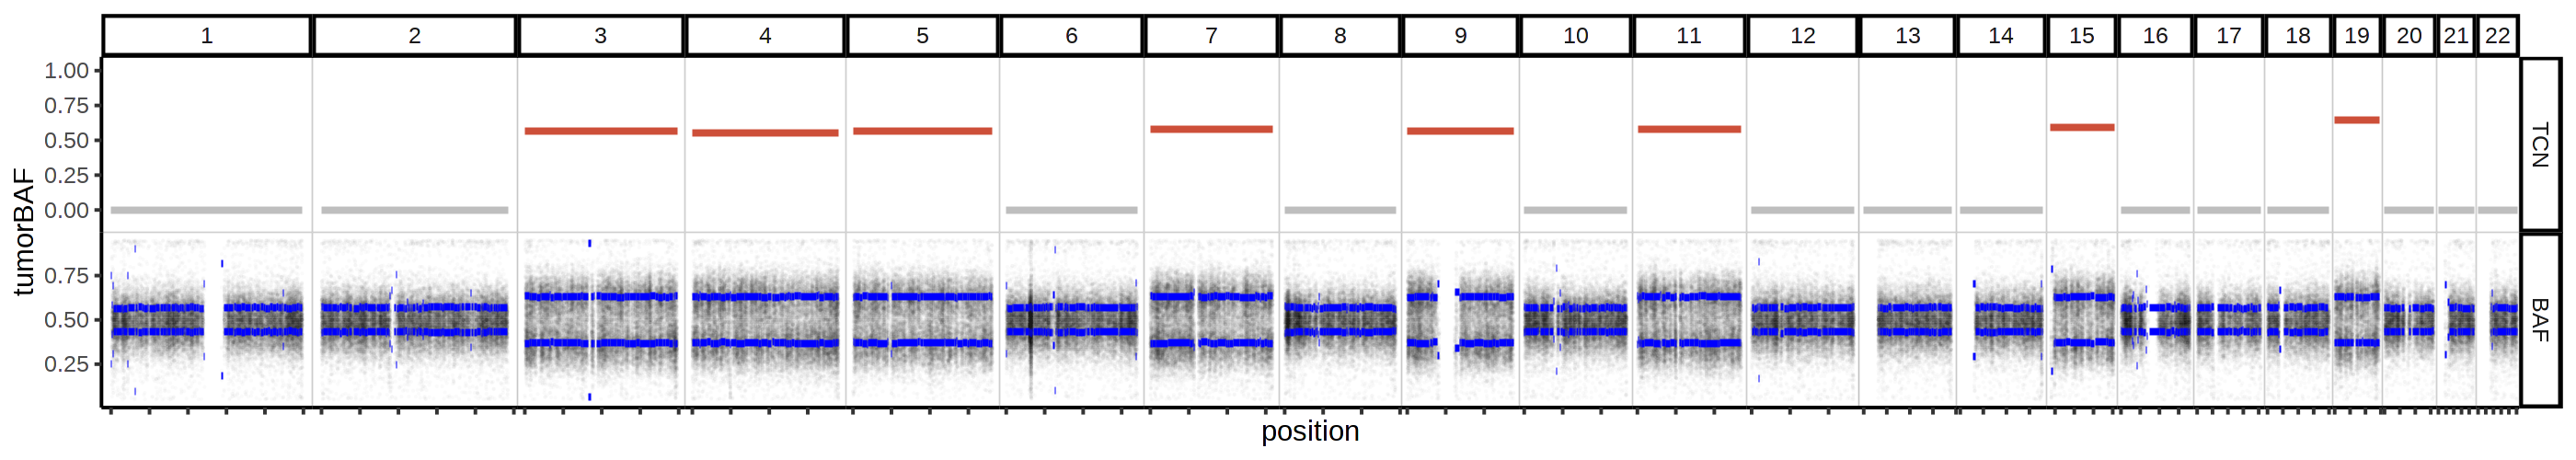

In [4561]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

In [187]:
baseline_chroms = c(1:2, 6, 8, 10, 12:14, 16:18, 20:22)

# define segments based on DNA
segs_dna = purple[[sample]]$cnv %>% 
    mutate(
        cnv_state = case_when(
            copyNumber > 2.5 ~ 'amp',
            copyNumber < 1.5 ~ 'del',
            observedBAF > 0.75 ~ 'loh',
            T ~ 'neu'
        )
    ) %>%
    mutate(
        cnv_state = ifelse(cnv_state == 'amp' & observedBAF < 0.58, 'bamp', cnv_state)
    ) %>%
    filter(cnv_state != 'neu' & bafCount > 500) %>% 
    group_by(CHROM, cnv_state) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        copyNumber = median(copyNumber),
        observedBAF = median(observedBAF),
        .groups = 'drop'
    ) %>%
    arrange(CHROM, seg_start)

segs_dna = segs_dna %>%
    group_by(CHROM) %>%
    mutate(
        seg = paste0(CHROM, '_', 1:n()),
        seg_cons = seg,
        p_loh = as.integer(cnv_state == 'loh'),
        p_amp = as.integer(cnv_state == 'amp'),
        p_del = as.integer(cnv_state == 'del'),
        p_bamp = as.integer(cnv_state == 'bamp'),
        p_bdel = as.integer(cnv_state == 'bdel')
    ) %>%
    ungroup()

segs_neu = purple[[sample]]$cnv %>%
    group_by(CHROM) %>%
    filter(CHROM %in% baseline_chroms) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end)
    )

segs_consensus_dna = segs_dna %>%
    fill_neu_segs(segs_neu) %>%
    mutate(copyNumber = ifelse(cnv_state == 'neu', 2, copyNumber)) %>%
    mutate(cnv_state_post = cnv_state) %>%
    mutate(seg = seg_cons)

In [183]:
segs_consensus_dna = fread(glue('~/results/benchmark/{sample}/segs_consensus_dna.tsv'), sep = '\t') %>% as.data.frame()

In [4563]:
# segs_consensus_dna %>% fwrite(glue('~/results/benchmark/{sample}/segs_consensus_dna.tsv'), sep = '\t')

# 27522

Warning message in mask$eval_all_mutate(quo):
“NaNs produced”


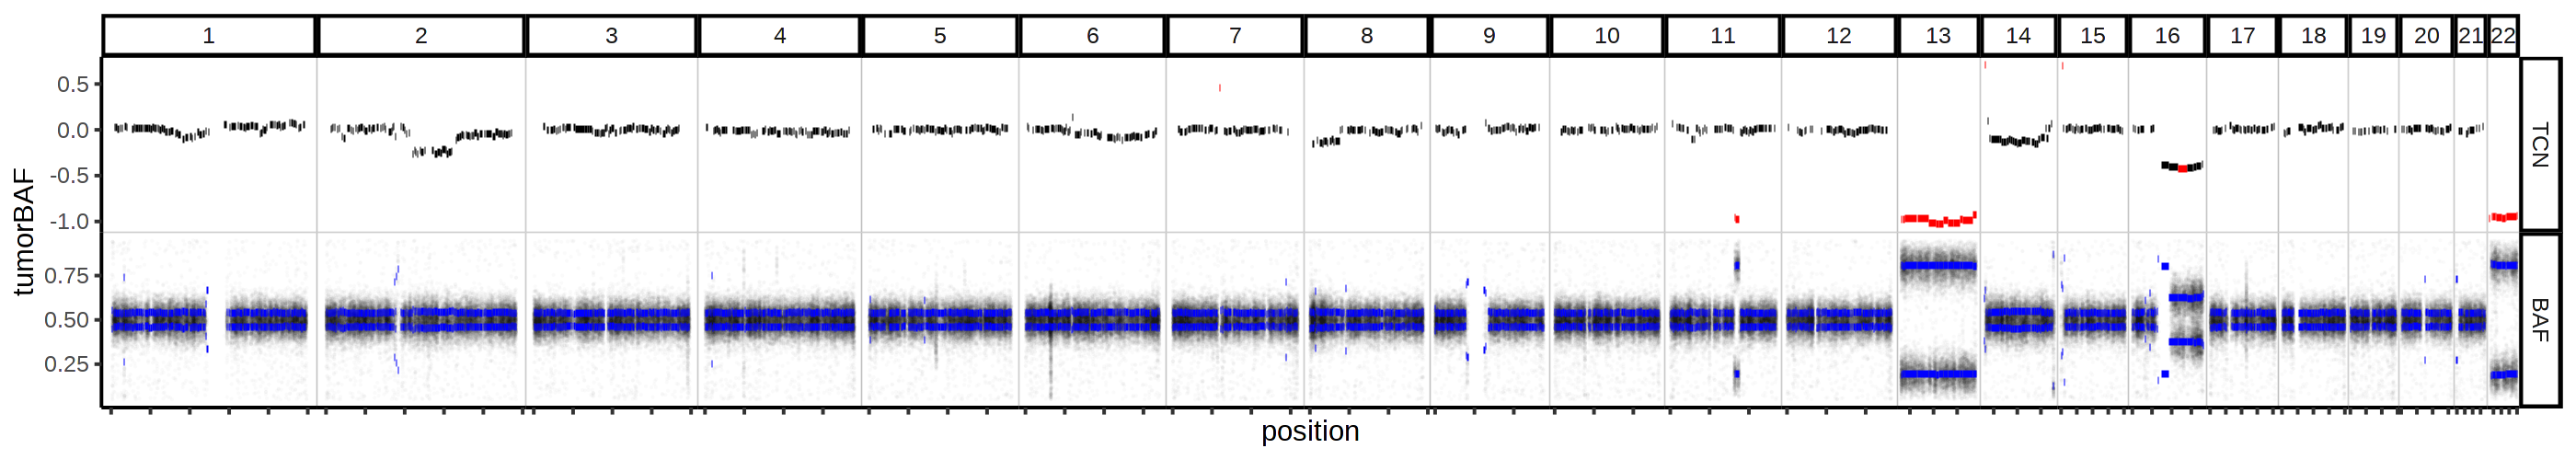

In [108]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
sample = '27522_Relapse_2'

purple[[sample]] = load_purple(sample)

plot_purple(purple[[sample]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



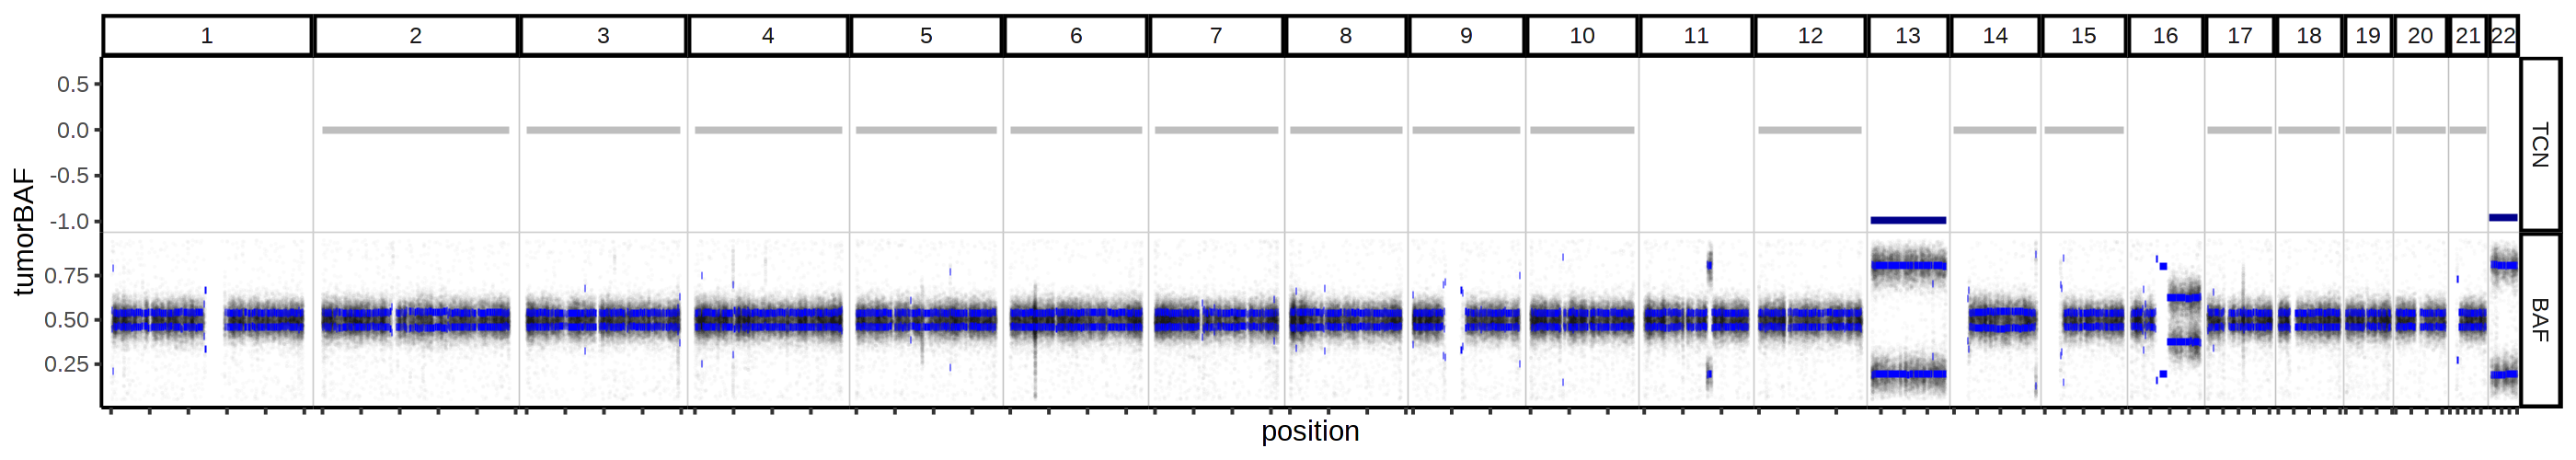

In [4390]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

In [191]:
baseline_chroms = c(2:10, 12, 14:15, 17:21)

# define segments based on DNA
segs_dna = purple[[sample]]$cnv %>% 
    mutate(
        cnv_state = case_when(
            copyNumber > 2.5 ~ 'amp',
            copyNumber < 1.5 ~ 'del',
            observedBAF > 0.75 ~ 'loh',
            T ~ 'neu'
        )
    ) %>%
    mutate(
        cnv_state = ifelse(cnv_state == 'amp' & observedBAF < 0.58, 'bamp', cnv_state)
    ) %>%
    filter(cnv_state != 'neu' & bafCount > 8000) %>% 
    group_by(CHROM, cnv_state) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        copyNumber = median(copyNumber),
        observedBAF = median(observedBAF),
        .groups = 'drop'
    ) %>%
    arrange(CHROM, seg_start)

segs_dna = segs_dna %>%
    group_by(CHROM) %>%
    mutate(
        seg = paste0(CHROM, '_', 1:n()),
        seg_cons = seg,
        p_loh = as.integer(cnv_state == 'loh'),
        p_amp = as.integer(cnv_state == 'amp'),
        p_del = as.integer(cnv_state == 'del'),
        p_bamp = as.integer(cnv_state == 'bamp'),
        p_bdel = as.integer(cnv_state == 'bdel')
    ) %>%
    ungroup()

segs_neu = purple[[sample]]$cnv %>%
    group_by(CHROM) %>%
    filter(CHROM %in% baseline_chroms) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end)
    )

segs_consensus_dna = segs_dna %>%
    fill_neu_segs(segs_neu) %>%
    mutate(copyNumber = ifelse(cnv_state == 'neu', 2, copyNumber)) %>%
    mutate(cnv_state_post = cnv_state) %>%
    mutate(seg = seg_cons)

In [192]:
segs_consensus_dna_old = fread(glue('~/results/benchmark/{sample}/segs_consensus_dna.tsv'), sep = '\t')

In [4392]:
# segs_consensus_dna %>% fwrite('~/results/benchmark/27522_Primary/segs_consensus_dna.tsv', sep = '\t')
# segs_consensus_dna %>% fwrite('~/results/benchmark/27522_Relapse_2/segs_consensus_dna.tsv', sep = '\t')

# 59114

## DNA

Warning message in mask$eval_all_mutate(quo):
“NaNs produced”


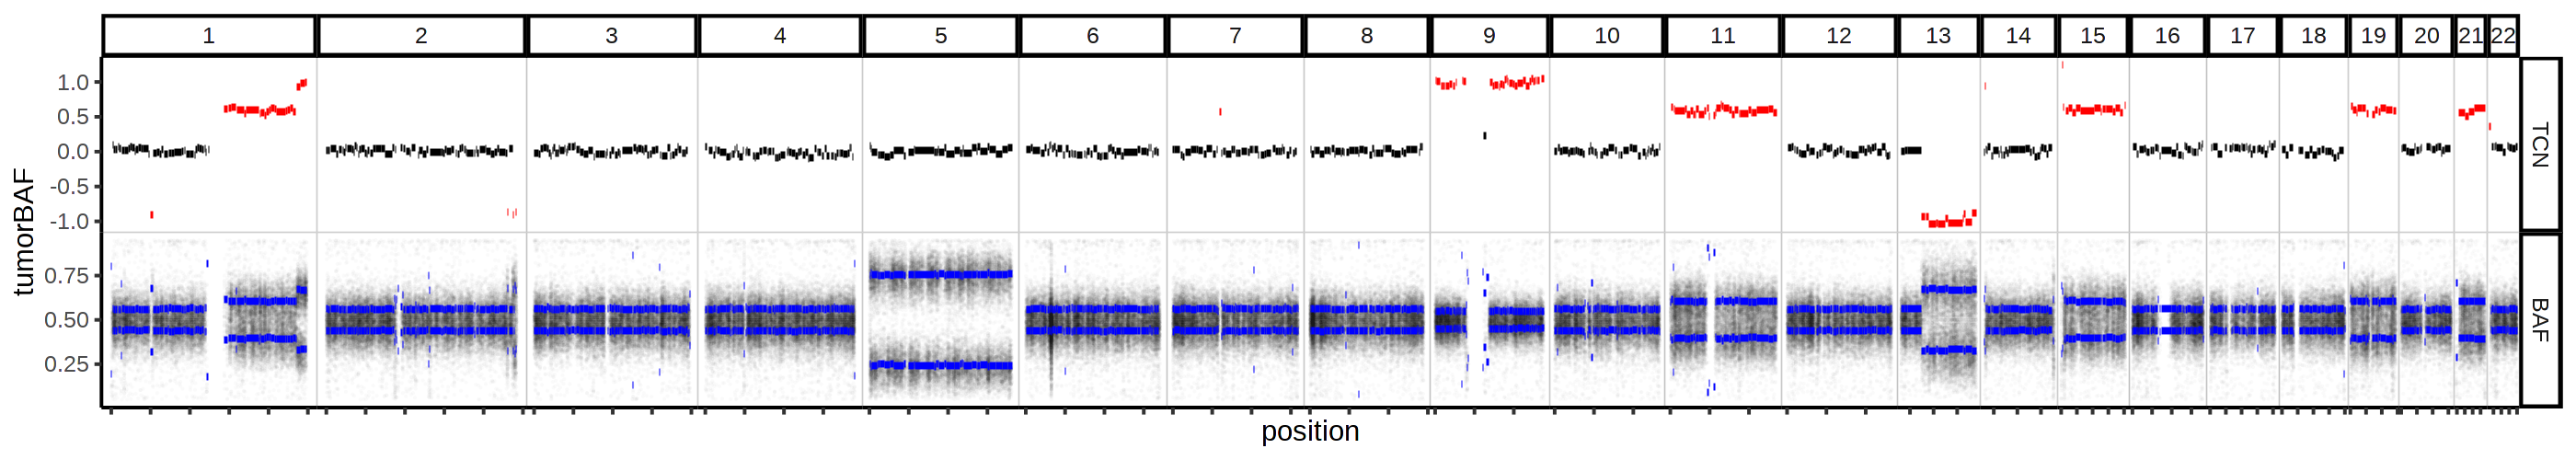

In [27]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)

sample = '59114_Relapse_1'

purple[[sample]] = load_purple(sample)

plot_purple(purple[[sample]])

In [368]:
fill_neu_segs = function (segs_consensus, segs_neu) 
{
    gaps = GenomicRanges::setdiff(segs_neu %>% {
        GenomicRanges::GRanges(seqnames = .$CHROM, IRanges::IRanges(start = .$seg_start, 
            end = .$seg_end))
    }, segs_consensus %>% {
        GenomicRanges::GRanges(seqnames = .$CHROM, IRanges::IRanges(start = .$seg_start, 
            end = .$seg_end))
    }, ) %>% suppressWarnings() %>% as.data.frame() %>% select(CHROM = seqnames, 
        seg_start = start, seg_end = end) %>% mutate(seg_length = seg_end - 
        seg_start) %>% filter(seg_length > 0)
    segs_consensus = segs_consensus %>% 
        mutate(seg_length = seg_end - seg_start) %>% 
        bind_rows(gaps) %>% 
        mutate(cnv_state = tidyr::replace_na(cnv_state, 
        "neu")) %>%
        arrange(CHROM, seg_start) %>% group_by(CHROM) %>% 
        mutate(seg_cons = paste0(CHROM, '_', 1:n())) %>% 
        ungroup() %>% mutate(CHROM = factor(CHROM, 1:22)) %>% 
        arrange(CHROM)
    return(segs_consensus)
}

In [377]:
baseline_chroms = c(1:8, 10, 12, 13, 14, 16:18, 20, 22)

# define segments based on DNA
segs_dna = purple[[sample]]$cnv %>% 
    mutate(
        cnv_state = case_when(
            copyNumber > 2.5 ~ 'amp',
            copyNumber < 1.5 ~ 'del',
            observedBAF > 0.75 ~ 'loh',
            T ~ 'neu'
        )
    ) %>%
    mutate(
        cnv_state = ifelse(cnv_state == 'amp' & observedBAF < 0.58, 'bamp', cnv_state)
    ) %>%
    filter(cnv_state != 'neu' & bafCount > 1500) %>% 
    group_by(CHROM, cnv_state) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        copyNumber = median(copyNumber),
        observedBAF = median(observedBAF),
        .groups = 'drop'
    ) %>%
    arrange(CHROM, seg_start)

segs_dna = segs_dna %>%
    group_by(CHROM) %>%
    mutate(
        seg = paste0(CHROM, '_', 1:n()),
        seg_cons = seg,
        p_loh = as.integer(cnv_state == 'loh'),
        p_amp = as.integer(cnv_state == 'amp'),
        p_del = as.integer(cnv_state == 'del'),
        p_bamp = as.integer(cnv_state == 'bamp'),
        p_bdel = as.integer(cnv_state == 'bdel')
    ) %>%
    ungroup()

segs_neu = purple[[sample]]$cnv %>%
    group_by(CHROM) %>%
    filter(CHROM %in% baseline_chroms) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end)
    )

segs_consensus_dna = segs_dna %>%
    fill_neu_segs(segs_neu) %>%
    mutate(copyNumber = ifelse(cnv_state == 'neu', 2, copyNumber)) %>%
    mutate(cnv_state_post = cnv_state) %>%
    mutate(seg = seg_cons)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



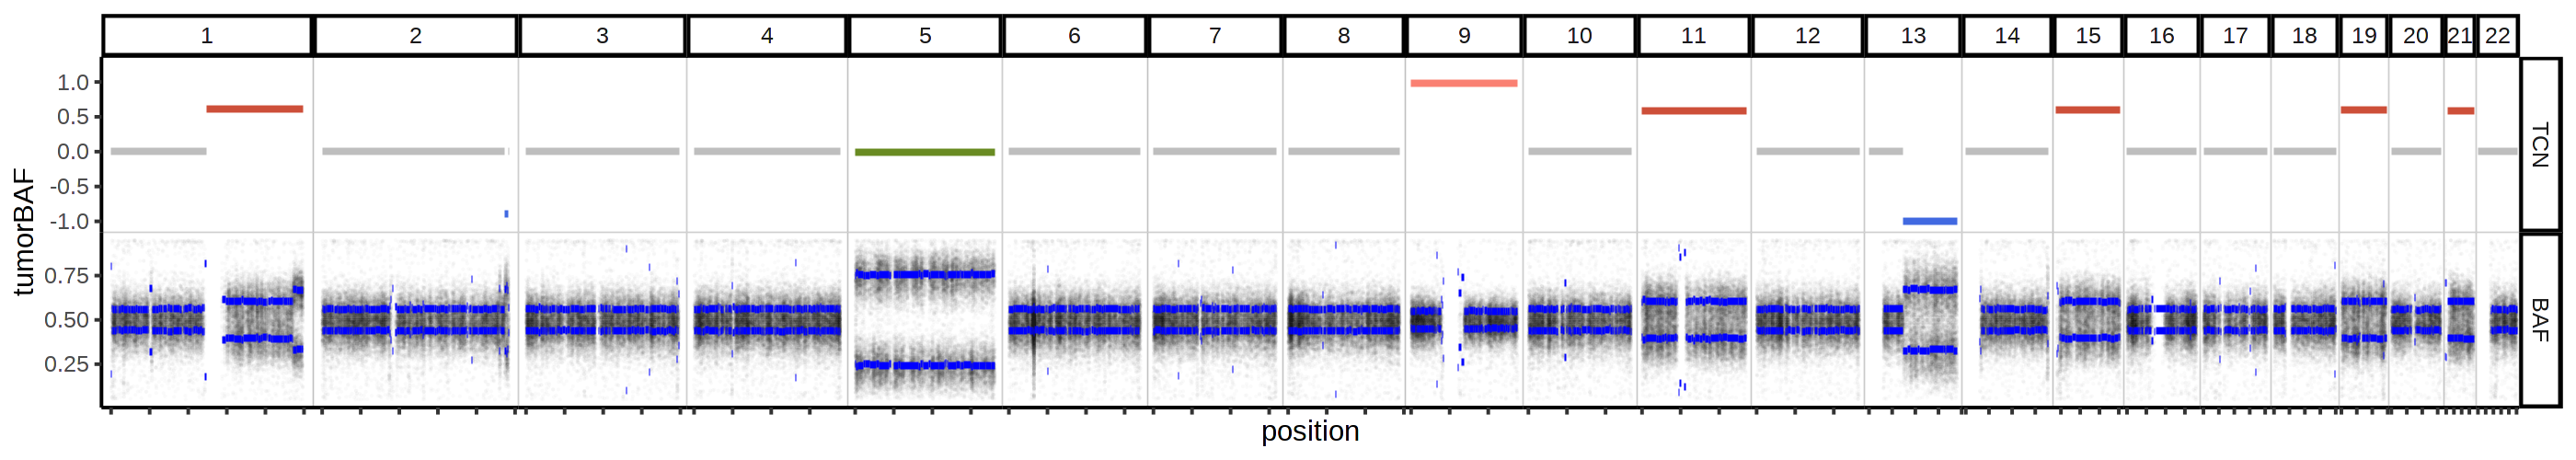

In [340]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



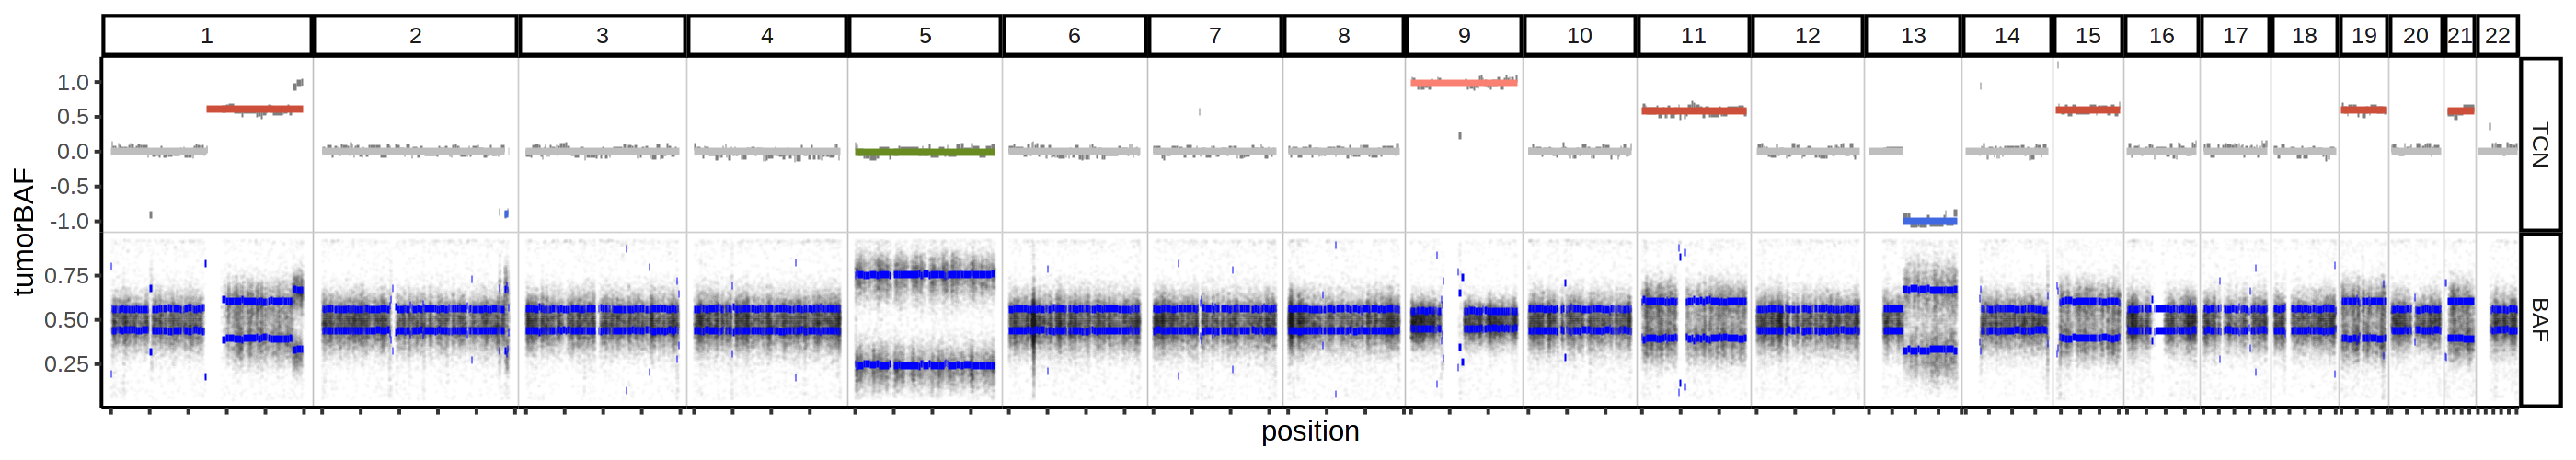

In [346]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
R.utils::sourceDirectory('~/Numbat/R')

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

In [203]:
segs_consensus_dna_old = fread(glue('~/results/benchmark/{sample}/segs_consensus_dna.tsv'), sep = '\t')

In [379]:
segs_consensus_dna %>% fwrite(glue('~/paper_data/purple_out/{sample}/segs_consensus_dna.tsv'), sep = '\t')

# 58408

## DNA

Warning message in mask$eval_all_mutate(quo):
“NaNs produced”


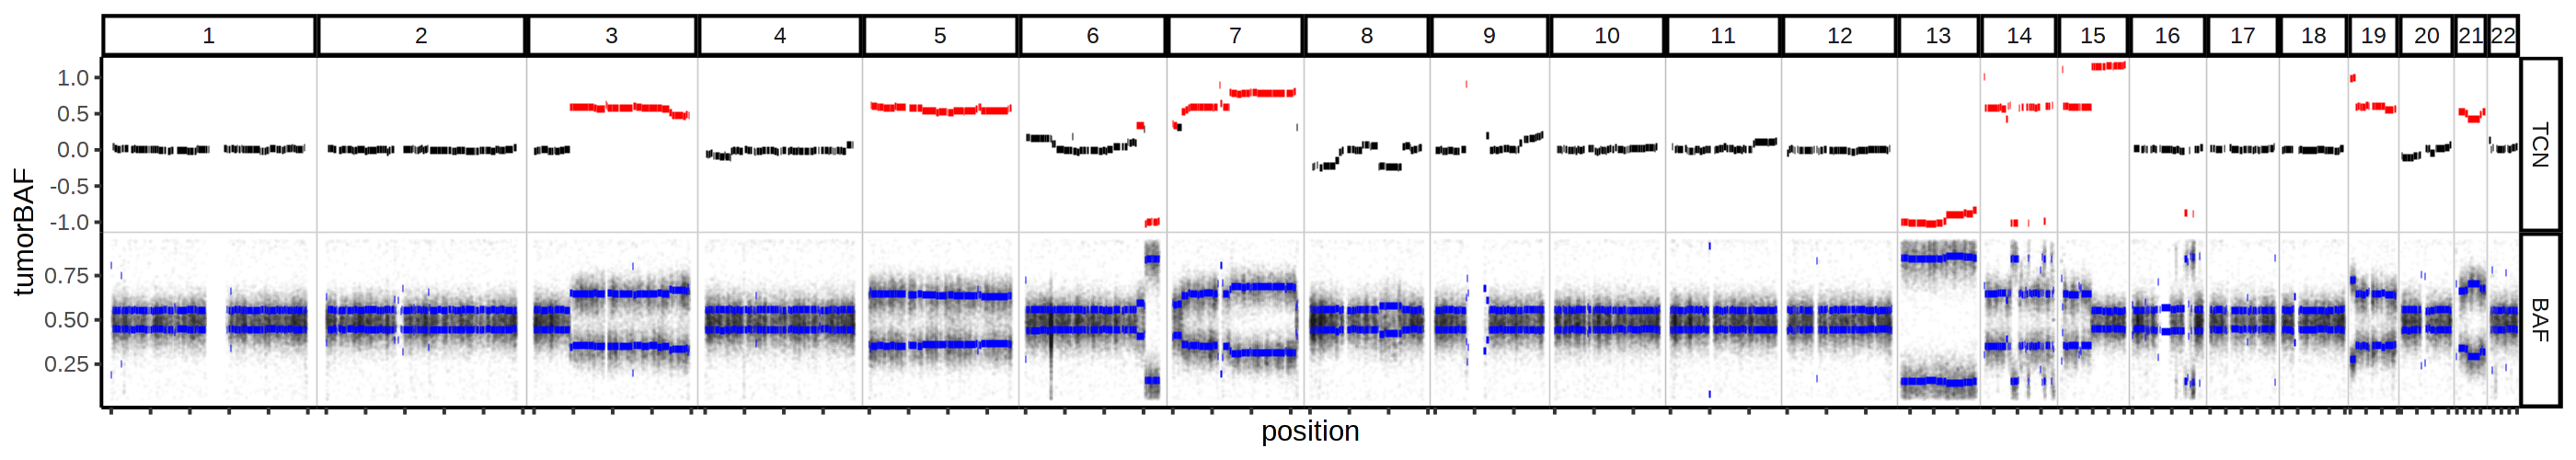

In [28]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
sample = '58408_Primary'

purple[[sample]] = load_purple(sample)

plot_purple(purple[[sample]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



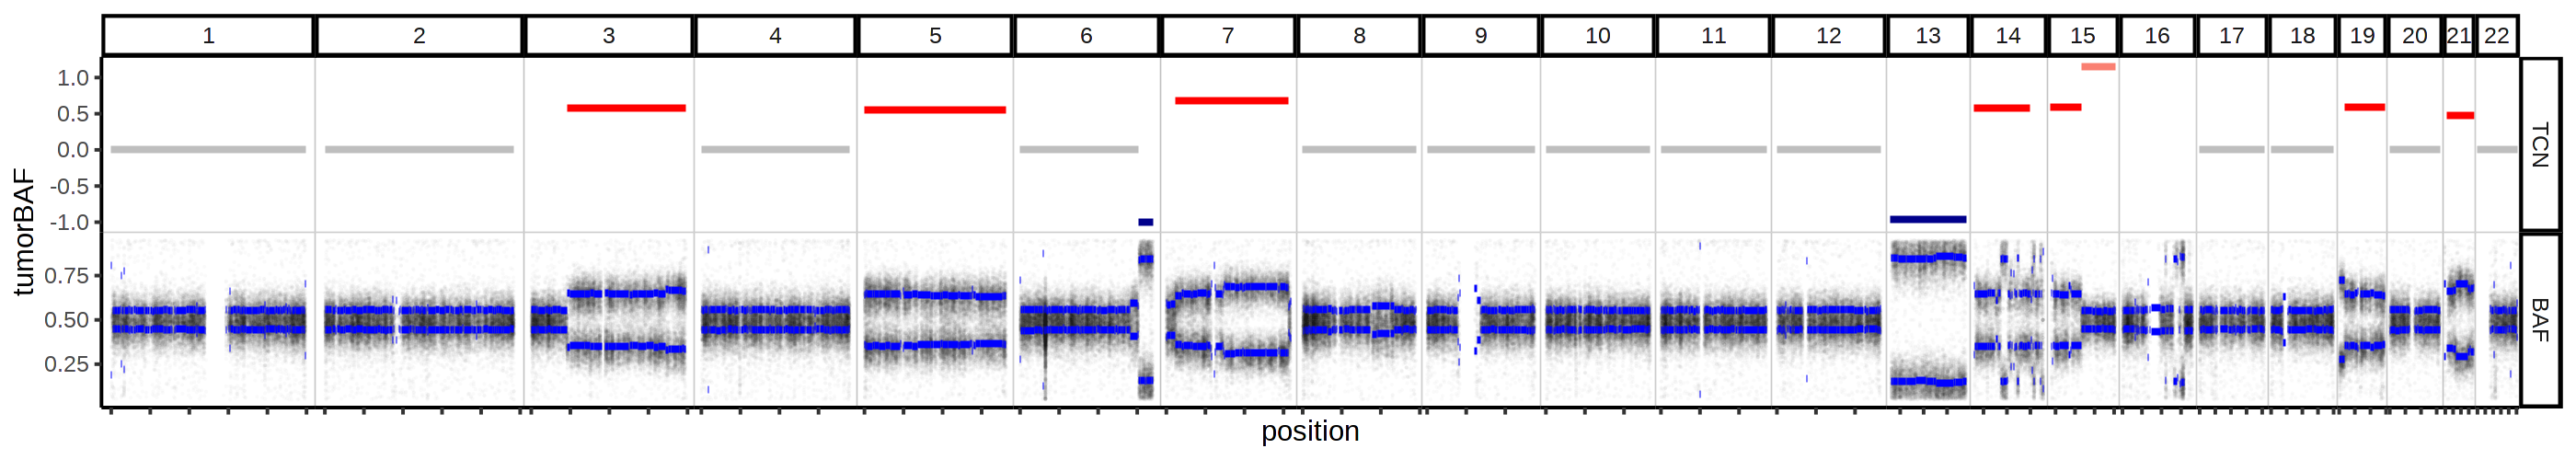

In [4327]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

In [224]:
# define segments based on DNA
segs_dna = purple[[sample]]$cnv %>% 
    mutate(
        cnv_state = case_when(
            copyNumber > 2.5 ~ 'amp',
            copyNumber < 1.5 ~ 'del',
            observedBAF > 0.75 ~ 'loh',
            T ~ 'neu'
        )
    ) %>%
    mutate(
        cnv_state = ifelse(cnv_state == 'amp' & observedBAF < 0.58, 'bamp', cnv_state)
    ) %>%
    filter(cnv_state != 'neu' & bafCount > 8000) %>% 
    group_by(CHROM, cnv_state) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        copyNumber = median(copyNumber),
        observedBAF = median(observedBAF),
        .groups = 'drop'
    ) %>%
    arrange(CHROM, seg_start)

segs_dna = segs_dna %>%
    group_by(CHROM) %>%
    mutate(
        seg = paste0(CHROM, '_', 1:n()),
        seg_cons = seg,
        p_loh = as.integer(cnv_state == 'loh'),
        p_amp = as.integer(cnv_state == 'amp'),
        p_del = as.integer(cnv_state == 'del'),
        p_bamp = as.integer(cnv_state == 'bamp'),
        p_bdel = as.integer(cnv_state == 'bdel')
    ) %>%
    ungroup()

baseline_chroms = c(1:2, 4, 6, 8:12, 17:18, 20, 22)

segs_neu = purple[[sample]]$cnv %>%
    group_by(CHROM) %>%
    filter(CHROM %in% baseline_chroms) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end)
    )

segs_consensus_dna = segs_dna %>%
    fill_neu_segs(segs_neu) %>%
    mutate(copyNumber = ifelse(cnv_state == 'neu', 2, copyNumber)) %>%
    mutate(cnv_state_post = cnv_state) %>%
    mutate(seg = seg_cons)

In [225]:
segs_consensus_dna_old = fread(glue('~/paper_data/purple_out/{sample}/segs_consensus_dna.tsv'), sep = '\t') %>% as.data.frame()

In [230]:
segs_consensus_dna %>% filter(cnv_state != 'neu')
segs_consensus_dna_old %>% filter(cnv_state != 'neu')

CHROM cnv_state seg_start seg_end   copyNumber observedBAF seg seg_cons
1  1     loh               1 107406000 1.98730    0.90700     1a  1a      
2  1     amp       123605523 248956422 2.85110    0.66900     1b  1b      
3  2     amp               1  93139350 3.47040    0.68650     2a  2a      
4  5     amp               1 181538259 2.99270    0.65120     5a  5a      
5  7     amp               1 159345973 3.00940    0.65300     7a  7a      
6  8     del               1  41509000 0.97680    0.85830     8a  8a      
7  9     amp               1 138394717 2.99265    0.65090     9a  9a      
8  10    amp        40640102 133797422 2.85795    0.64280     10a 10a     
9  11    amp               1 135086622 3.00020    0.65145     11a 11a     
10 15    bamp       18362627 101991189 3.99840    0.54500     15a 15a     
11 19    bamp              1  58617616 3.84275    0.54755     19a 19a     
   p_loh p_amp p_del p_bamp p_bdel seg_length cnv_state_post
1  1     0     0     0      0      107405999  loh           
2  0     1     0     0      0      125350899  amp           
3  0     1     0     0      0       93139349  amp           
4  0     1     0     0      0      181538258  amp           
5  0     1     0     0      0      159345972  amp           
6  0     0     1     0      0       41508999  del           
7  0     1     0     0      0      138394716  amp           
8  0     1     0     0      0       93157320  amp           
9  0     1     0     0      0      135086621  amp           
10 0     0     0     1      0       83628562  bamp          
11 0     0     0     1      0       58617615  bamp

CHROM cnv_state seg_start seg_end   copyNumber observedBAF seg  seg_cons
1  3    amp        45733001 198295559 2.98080    0.64920     3_1  3_1     
2  5    amp               1 181538259 2.92900    0.64100     5_1  5_1     
3  6    del       151801001 170805979 1.00130    0.84170     6_2  6_2     
4  7    amp        11855001 156595000 3.20850    0.66535     7_1  7_1     
5 13    del        17025624 114364328 1.02760    0.84990     13_1 13_1    
6 15    amp        18362627  58147000 3.01360    0.64480     15_1 15_1    
7 15    bamp       58147001 101991189 4.45600    0.55130     15_2 15_2    
8 19    amp         6610001  58617616 3.01025    0.64560     19_1 19_1    
9 21    amp        11890184  46709983 2.77260    0.68450     21_1 21_1    
  p_loh p_amp p_del p_bamp p_bdel seg_length cnv_state_post
1 0     1     0     0      0      152562558  amp           
2 0     1     0     0      0      181538258  amp           
3 0     0     1     0      0       19004978  del           
4 0     1     0     0      0      144739999  amp           
5 0     0     1     0      0       97338704  del           
6 0     1     0     0      0       39784373  amp           
7 0     0     0     1      0       43844188  bamp          
8 0     1     0     0      0       52007615  amp           
9 0     1     0     0      0       34819799  amp

In [4330]:
# segs_consensus_dna %>% filter(!CHROM %in% c(14)) %>% 
#     fwrite('~/results/benchmark/58408_Primary/segs_consensus_dna.tsv', sep = '\t')

# segs_consensus_dna %>% filter(!CHROM %in% c(14, 5)) %>% 
#     fwrite('~/results/benchmark/58408_SMM/segs_consensus_dna.tsv', sep = '\t')

# 47491

## DNA

Warning message in mask$eval_all_mutate(quo):
“NaNs produced”


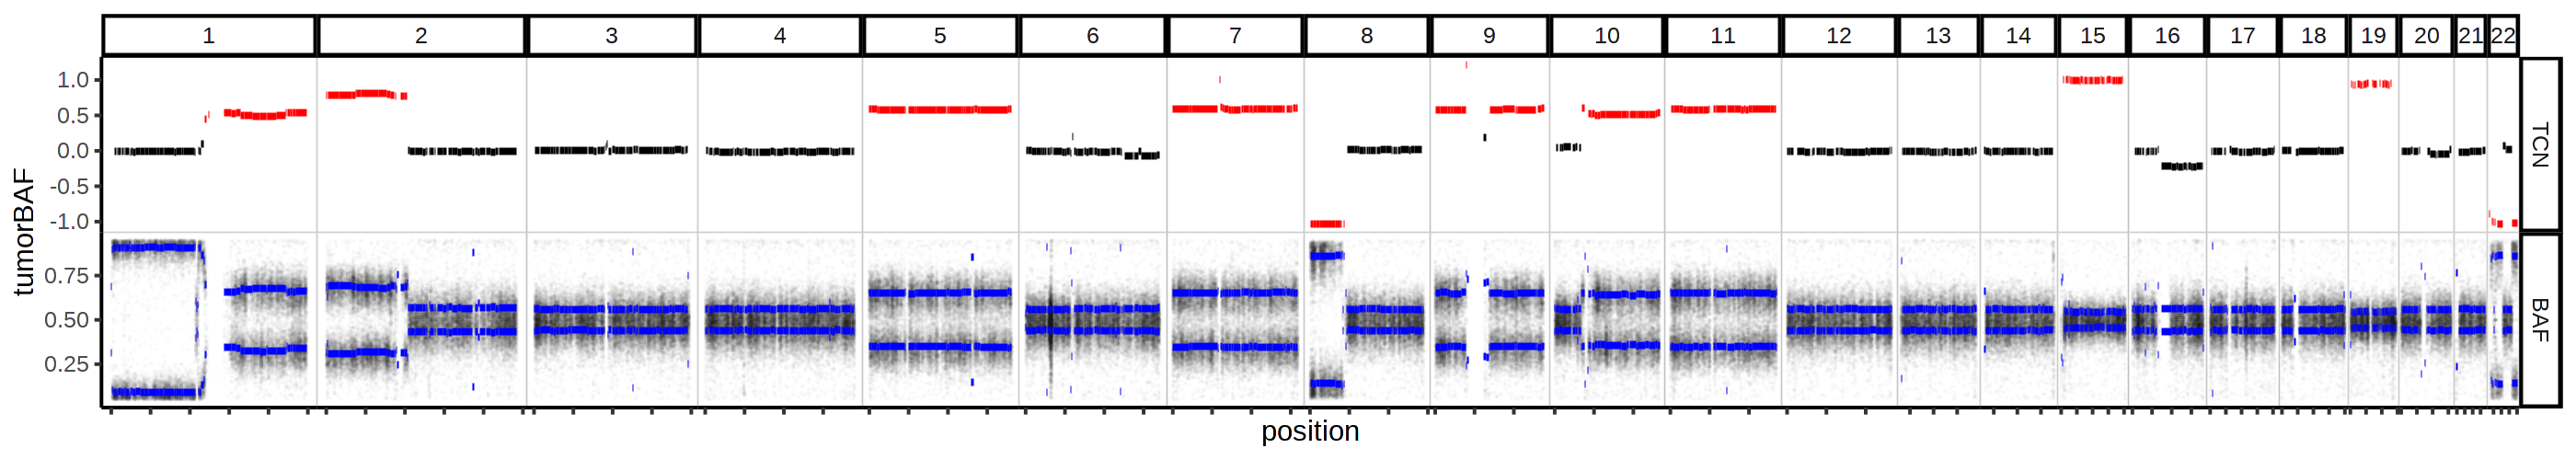

In [41]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)
sample = '47491_Primary'

purple[[sample]] = load_purple(sample)

plot_purple(purple[[sample]])

In [236]:
# define segments based on DNA
segs_dna = purple[[sample]]$cnv %>% 
    mutate(
        cnv_state = case_when(
            copyNumber > 2.5 ~ 'amp',
            copyNumber < 1.5 ~ 'del',
            observedBAF > 0.75 ~ 'loh',
            T ~ 'neu'
        )
    ) %>%
    filter(cnv_state != 'neu' & bafCount > 10000) %>% 
    group_by(CHROM, cnv_state) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end),
        copyNumber = median(copyNumber),
        observedBAF = median(observedBAF),
        .groups = 'drop'
    ) %>%
    mutate(
        cnv_state = ifelse(cnv_state == 'amp' & observedBAF < 0.58, 'bamp', cnv_state)
    ) %>%
    arrange(CHROM, seg_start)

segs_dna = segs_dna %>%
    group_by(CHROM) %>%
    mutate(
        seg = paste0(CHROM, '_', 1:n()),
        seg_cons = seg,
        p_loh = as.integer(cnv_state == 'loh'),
        p_amp = as.integer(cnv_state == 'amp'),
        p_del = as.integer(cnv_state == 'del'),
        p_bamp = as.integer(cnv_state == 'bamp'),
        p_bdel = as.integer(cnv_state == 'bdel')
    ) %>%
    ungroup()

baseline_chroms = c(3, 4, 6, 12:14, 17:18, 20:21)

segs_neu = purple[[sample]]$cnv %>%
    group_by(CHROM) %>%
    filter(CHROM %in% baseline_chroms) %>%
    summarise(
        seg_start = min(start),
        seg_end = max(end)
    )

segs_consensus_dna = segs_dna %>%
    fill_neu_segs(segs_neu) %>%
    mutate(copyNumber = ifelse(cnv_state == 'neu', 2, copyNumber)) %>%
    mutate(cnv_state_post = cnv_state) %>%
    mutate(seg = seg_cons)

In [237]:
segs_consensus_dna_old = fread(glue('~/results/benchmark/{sample}/segs_consensus_dna.tsv'), sep = '\t')

In [238]:
segs_consensus_dna %>% filter(cnv_state != 'neu')
segs_consensus_dna_old %>% filter(cnv_state != 'neu')

CHROM cnv_state seg_start seg_end   copyNumber observedBAF seg seg_cons
1  1     loh               1 107406000 1.98730    0.90700     1a  1a      
2  1     amp       123605523 248956422 2.85110    0.66900     1b  1b      
3  2     amp               1  93139350 3.47040    0.68650     2a  2a      
4  5     amp               1 181538259 2.99270    0.65120     5a  5a      
5  7     amp               1 159345973 3.00940    0.65300     7a  7a      
6  8     del               1  41509000 0.97680    0.85830     8a  8a      
7  9     amp               1 138394717 2.99265    0.65090     9a  9a      
8  10    amp        40640102 133797422 2.85795    0.64280     10a 10a     
9  11    amp               1 135086622 3.00020    0.65145     11a 11a     
10 15    bamp       18362627 101991189 3.99840    0.54500     15a 15a     
11 19    bamp              1  58617616 3.84275    0.54755     19a 19a     
   p_loh p_amp p_del p_bamp p_bdel seg_length cnv_state_post
1  1     0     0     0      0      107405999  loh           
2  0     1     0     0      0      125350899  amp           
3  0     1     0     0      0       93139349  amp           
4  0     1     0     0      0      181538258  amp           
5  0     1     0     0      0      159345972  amp           
6  0     0     1     0      0       41508999  del           
7  0     1     0     0      0      138394716  amp           
8  0     1     0     0      0       93157320  amp           
9  0     1     0     0      0      135086621  amp           
10 0     0     0     1      0       83628562  bamp          
11 0     0     0     1      0       58617615  bamp

CHROM cnv_state seg_start seg_end   copyNumber observedBAF seg  seg_cons
1   1    loh               1 107406000 1.98730    0.90700     1_1  1_1     
2   1    amp       123605523 248956422 2.85110    0.66900     1_2  1_2     
3   2    amp               1  93139350 3.47040    0.68650     2_1  2_1     
4   5    amp               1 181538259 2.99270    0.65120     5_1  5_1     
5   7    amp               1 159345973 3.00940    0.65300     7_1  7_1     
6   8    del               1  41509000 0.97680    0.85830     8_1  8_1     
7   9    amp               1 138394717 2.99265    0.65090     9_1  9_1     
8  10    amp        40640102 133797422 2.85795    0.64280     10_1 10_1    
9  11    amp               1 135086622 3.00020    0.65145     11_1 11_1    
10 15    bamp       18362627 101991189 3.99840    0.54500     15_1 15_1    
11 19    bamp              1  58617616 3.84275    0.54755     19_1 19_1    
   p_loh p_amp p_del p_bamp p_bdel seg_length cnv_state_post
1  1     0     0     0      0      107405999  loh           
2  0     1     0     0      0      125350899  amp           
3  0     1     0     0      0       93139349  amp           
4  0     1     0     0      0      181538258  amp           
5  0     1     0     0      0      159345972  amp           
6  0     0     1     0      0       41508999  del           
7  0     1     0     0      0      138394716  amp           
8  0     1     0     0      0       93157320  amp           
9  0     1     0     0      0      135086621  amp           
10 0     0     0     1      0       83628562  bamp          
11 0     0     0     1      0       58617615  bamp

In [4355]:
# segs_consensus_dna %>% fwrite('~/results/benchmark/47491_Primary/segs_consensus_dna.tsv', sep = '\t')
# segs_consensus_dna %>% fwrite('~/results/benchmark/47491_SMM/segs_consensus_dna.tsv', sep = '\t')

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



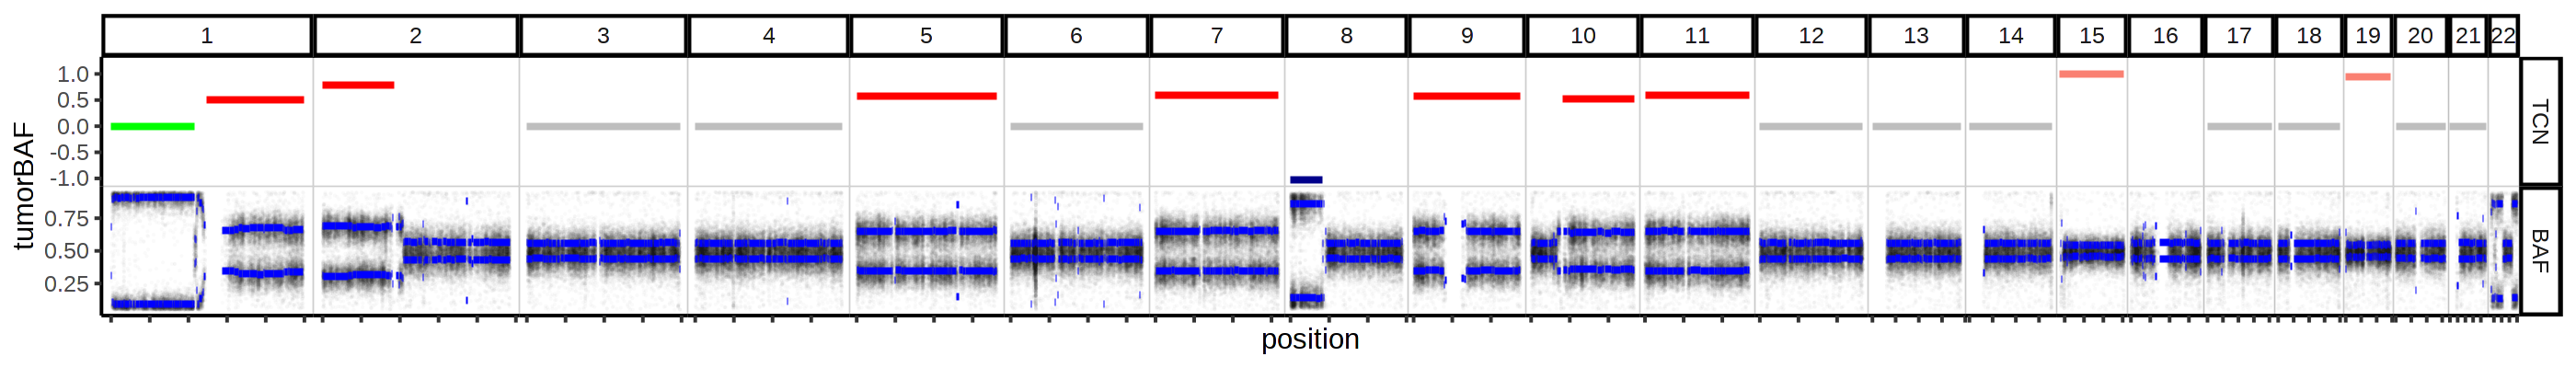

In [3884]:
options(repr.plot.width = 14, repr.plot.height = 2.5, repr.plot.res = 200)

plot_purple(purple[[sample]]) +
geom_segment(
    data = segs_consensus_dna %>% mutate(variable = factor('TCN', c('TCN', 'BAF'))),
    aes(x = seg_start, xend = seg_end, y = log2(copyNumber/2), yend = log2(copyNumber/2), color = cnv_state),
    size = 1
) +
scale_color_manual(values = cnv_colors)

# Scoring

In [343]:
sample = '59114_Relapse_1'

In [380]:
samples = c('58408_Primary', '47491_Primary', '27522_Relapse_2', '59114_Relapse_1', '37692_Primary')

scores = c()

for (sample in samples) {
    
    message(sample)
    
    segs_consensus = fread(glue('~/paper_data/purple_out/{sample}/segs_consensus_dna.tsv')) %>%
        mutate(CHROM = factor(CHROM, 1:22))

    scores.copykat = score_copykat(sample, segs_consensus)$scores
    scores.infercnv = score_infercnv(sample, segs_consensus)$scores
    
#     joint_post = fread(glue('~/results/benchmark/{sample}/hca/joint_post.tsv')) %>% 
    joint_post = fread(glue('~/paper_data/cnv_benchmark/{sample}_new/joint_post.tsv')) %>%
        mutate(CHROM = factor(CHROM, 1:22))
    
    scores.numbat = joint_post %>%
        mutate(logBF_x = Z_cnv_x - Z_n_x, logBF_y = Z_cnv_y - Z_n_y) %>%
        mutate(CHROM = as.factor(CHROM)) %>%
        select(cell, seg, cnv_state, CHROM, logBF, logBF_x, logBF_y) %>%
        reshape2::melt(id.var = c('cell', 'seg', 'cnv_state', 'CHROM'), value.name = 'score', variable.name = 'method') %>%
        mutate(method = c('logBF' = 'numbat_joint', 'logBF_x' = 'numbat_exp', 'logBF_y' = 'numbat_allele')[method]) %>%
        mutate(norm = T)
    
    scores.hb = fread(glue('~/results/benchmark/{sample}_hb_sc.tsv')) %>%
        left_join(segs_consensus %>% select(seg, cnv_state), by = 'seg') %>%
        mutate(score = ifelse(cnv_state %in% c('amp', 'bamp'), p_amp, p_del)) %>%
        mutate(CHROM = factor(as.integer(CHROM))) %>%
        mutate(method = 'hb')

    cells_common = unique(scores.numbat$cell) %>%
        intersect(unique(scores.copykat$cell)) %>%
        intersect(unique(scores.infercnv$cell)) %>%
        intersect(unique(scores.hb$cell))

    scores[[sample]] = bind_rows(
            scores.copykat, scores.numbat, scores.infercnv, scores.hb
        ) %>%
        filter(cell %in% cells_common) %>%
        mutate(sample = UQ(sample)) %>%
        left_join(cell_annot[[sample]], by = c('cell', 'sample')) %>%
        mutate(y = as.integer(annot == 'T'))
}

58408_Primary

47491_Primary

27522_Relapse_2

59114_Relapse_1

37692_Primary



In [87]:
# averaged across events
set.seed(0)
auc_all = mclapply(
    mc.cores = 30,
    1:100, 
    function(i) {
        scores %>%
        bind_rows() %>%
        filter(!cnv_state %in% c('loh', 'neu')) %>%
#         filter((!norm) | str_detect(method, 'numbat'))  %>%
#         filter(norm) %>%
        group_by(sample, CHROM, norm) %>%
        sample_frac(1, replace = T) %>%
        group_by(method, norm) %>%
        summarise(
            auc = as.numeric(pROC::auc(y, score, direction = '<', levels = levels(as.factor(y)))),
            .groups = 'drop'
        ) %>%
        mutate(i = i) %>%
        suppressMessages()
}) %>%
bind_rows()

In [102]:
S = scores %>%
    bind_rows() %>%
    filter(!cnv_state %in% c('loh', 'neu')) %>%
    filter(norm) %>%
    split(.$method) %>%
    lapply(
        function(S) {
            
            roc_out = pROC::roc(S$y, S$score, direction = '<', levels = levels(as.factor(S$y)))
            
            data.frame(
                recall = roc_out$sensitivities,
                precision = roc_out$specificities,
                method = unique(S$method)
            )
            
        }
    ) %>%
    bind_rows()

In [98]:
roc_out = pROC::roc(S$y, S$score, direction = '<', levels = levels(as.factor(S$y)))

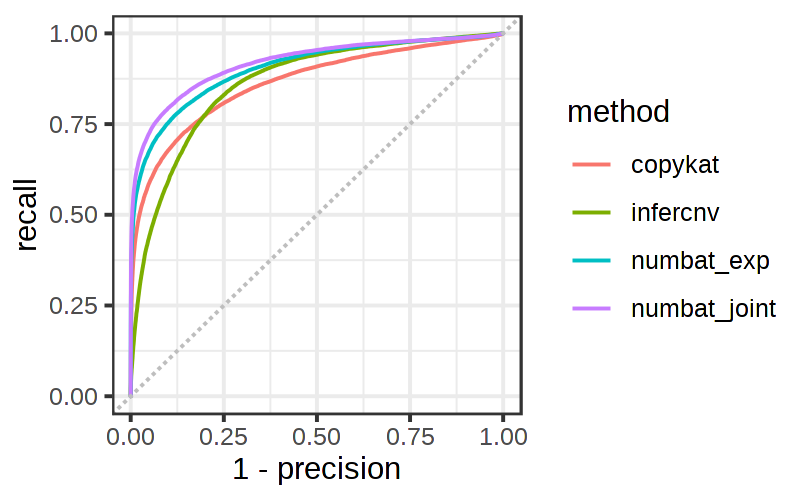

In [112]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)

ggplot(
    S %>% filter(method != 'numbat_allele'),
    aes(y = recall, x = 1-precision, color = method)
) +
geom_line() +
theme_bw() +
geom_abline(slope = 1, intercept = 0, linetype = 'dashed', color = 'gray')

In [388]:
scores = readRDS('~/paper_data/cnv_benchmark/sc_scores.rds')

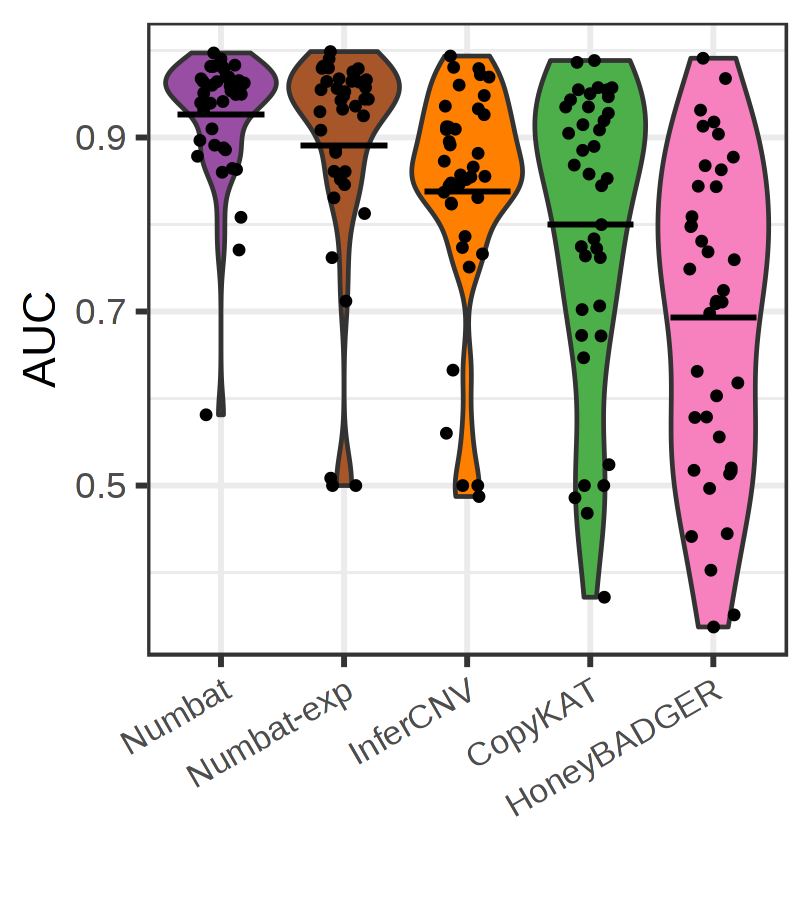

In [389]:
samples = c('58408_Primary', '47491_Primary', '27522_Relapse_2', '59114_Relapse_1', '37692_Primary')
pal = RColorBrewer::brewer.pal(n = 8, 'Set1')
methods = c('numbat_joint' = 'Numbat', 'numbat_exp' = 'Numbat-exp', 'numbat_allele',
            'infercnv' = 'InferCNV', 'copykat' = 'CopyKAT', 'hb' = 'HoneyBADGER')
method_colors = c('CopyKAT' = pal[3], 'Numbat' = pal[4], 'Numbat-exp' = pal[7], 'InferCNV' = pal[5], 'HoneyBADGER' = pal[8])

set.seed(0)

D = scores %>%
    bind_rows() %>%
    filter(!norm | str_detect(method, 'numbat|hb')) %>%
    filter(sample %in% samples) %>%
    filter(!cnv_state %in%  c('neu')) %>%
    mutate(score = ifelse(cnv_state == 'loh' & method %in% c('infercnv', 'copykat'), 0, score)) %>%
    filter(!cell %in% cells_incomplete) %>%
    group_by(method, sample, seg, cnv_state) %>%
    summarise(
        auc = as.numeric(pROC::auc(y, score, direction = '<', levels = levels(as.factor(y)))),
        n = n(),
        .groups = 'drop'
    ) %>%
    suppressMessages() %>% 
    filter(method != 'numbat_allele') %>%
    mutate(method = factor(method, names(methods))) %>%
    arrange(method) %>%
    mutate(method = methods[method]) %>%
    mutate(method = factor(method, unique(method)))

p = ggplot(
        D,
        aes(x = method, y = auc, group = method, fill = method)
    ) +
    theme_bw() +
    geom_violin(
#         draw_quantiles = c(0.5), 
        size = 0.4, scale = 'width'
    ) +
    stat_summary(fun=mean, geom="crossbar", size = 0.2, width = 0.7) +
    geom_jitter(size = 1, width = 0.2, alpha = 1, pch = 16) +
    theme(
        strip.text = element_text(size = 7),
        axis.text.x = element_text(angle = 30, hjust = 1, size = 8),
        strip.background = element_blank(),
        legend.position = 'none'
    ) +
    ylab('AUC') +
    xlab('') +
#     coord_cartesian(ylim=c(0,1)) +
#     facet_wrap(~sample, nrow = 1, scale = 'free') +
    scale_fill_manual(values = method_colors)

do_plot(p, 'benchmark_sc', 2.7, 3)